# Redes neuronales 4

Vamos a crear una red neuronal para tratar ahora con un conjunto mucho más grande, el *dataset* MNIST. Verás que, a medida que tratamos con conjuntos mayores, el tiempo de procesamiento se incrementa y la necesidad de contar con una GPU crece al mismo ritmo. Échale un vistazo a [este vídeo](https://www.youtube.com/watch?v=qcOjR-sJkUY) para que te vayas familiarizando con Google Colab, por si necesitas usarlo.




### Conjunto MNIST

El [conjunto MNIST](https://en.wikipedia.org/wiki/MNIST_database) está formado por 70.000 imágenes de dígitos manuscritos del 0 al 9 con un tamaño de 28x28 en escala de grises. A su vez, el conjunto se divide en 60.000 imágenes para entrenamiento y 10.000 para test."https://www.youtube.com/embed/S_f2qV2_U00?rel=0&amp;controls=0&amp;showinfo=0" frame


<img src="imgs/mnist.jpg" width="80%">

Vamos a utilizar este *dataset* para entrenar una red y ver qué precisión obtenemos al clasificar el conjunto de test. Piensa bien lo que pretendemos lograr: **hacer una red que será capaz de “ver”**, aunque, por ahora, solo sean imágenes de dos dimensiones.


El conjunto MNIST es muy popular y se utiliza mucho para aprender y probar redes, así que Keras ya lo incluye como parte de la librería.

Using TensorFlow backend.


Shape: (60000, 28, 28)


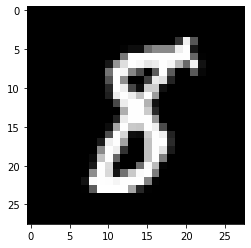

Label: 8


In [2]:
import keras
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Veamos la forma tiene x_train
print("Shape:", x_train.shape)  # 60.000 imágenes de 28x28

# Veamos una imagen cualquiera, por ejemplo, con el índice 125
image = np.array(x_train[125], dtype='float')
plt.imshow(image, cmap='gray')
plt.show()

print("Label:", y_train[125])

También es necesario saber en qué rango de valores se mueven nuestras muestras.

In [3]:
print("Max value:", max(x_train[125].reshape(784)))
print("Min value:", min(x_train[125].reshape(784)))

Max value: 255
Min value: 0


Vemos que cada pixel es un byte con un rango de valores que va desde el 0 hasta el 255 en formato entero. Esta escala no es muy adecuada para la red. Podemos facilitar mucho el trabajo de entrenamiento si transformamos esta escala en otra centrada en el 0 y con un rango de valores entre -0.5 y 0.5. Y, por supuesto, en formato real.

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255  # Escalamos a un rango entre 0 y 1
x_test /= 255

x_train -= 0.5  # desplazamos el rango a -0.5 y 0.5
x_test -= 0.5

print("Max value:", max(x_train[125].reshape(784)))
print("Min value:", min(x_train[125].reshape(784)))

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

Max value: 0.5
Min value: -0.5


Ahora preparamos las etiquetas transformándolas a formato *one_hot*. Keras tiene funciones para ello.

In [5]:
y_train = keras.utils.to_categorical(y_train, 10)  # 10 clases
y_test = keras.utils.to_categorical(y_test, 10)

print("Label:", y_train[125])  # Recordemos que esta muestra tenía valor 8

Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### Preparación del modelo

Tenemos que clasificar imágenes en diez categorías distintas, luego la capa final tendrá diez salidas. En cuanto a la capa de entrada, tenemos una matriz de $28 \times 28$. Lo que vamos a hacer es transformarla en un vector de $784$ componentes (
$28\times28=784$). Simplemente tomaremos cada fila de la matriz y las iremos colocando secuencialmente.

Para la capa o capas ocultas vamos a probar primero con una capa oculta con 20 neuronas. Recuerda que estos son los **hiperparámetros** de los que ya hemos hablado. No hay forma de saber *a priori* cuál es el número óptimo de capas ni de neuronas por capa oculta.

Como funciones de activación utilizaremos sigmoides y, en la capa final, softmax.

En lugar de definir la red de nuevo con el modelo secuencial de Keras, vamos a hacerlo con la [API funcional](https://keras.io/getting-started/functional-api-guide/). Esta API nos sirve para poder definir modelos más complejos que los simplemente creados a partir de acumular capas apiladas. Hay redes que tienen arquitecturas donde hay capas compartidas, las salidas de una capa pueden ir a capas separadas varias capas, etc. Hay una gran variedad. 

Por supuesto, la red que vamos a hacer ahora la podríamos hacer perfectamente con el modelo secuencial (y hasta nos sería más fácil), pero vamos a aprender a utilizar esta API.

In [6]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(784,))  # Capa de entrada
output_h = Dense(units=20, activation='sigmoid')(inputs)  # Capa oculta
predictions = Dense(10, activation='softmax')(output_h)  # Capa de salida

model = Model(inputs=inputs, outputs=predictions)

Si te has fijado, la API funcional usa la función <code>Dense(units=20, activation='sigmoid')(inputs)</code> para crear una capa en lugar del método <code>model.add(Dense(units=20, activation='sigmoid', input_dim=784))</code> del modelo. Esto nos da libertad para asignar la salida de una capa a la entrada de la capa que queramos, no obligatoriamente a la siguiente.

### Entrenamiento


In [7]:
model.compile(loss='mse',
              optimizer=keras.optimizers.SGD(lr=1),
              metrics=['accuracy'])

Durante el entrenamiento vamos a ir viendo también cómo va evolucionando el *accuracy* del conjunto de test. Cuando usamos el conjunto de test de esta manera se suele llamar **conjunto de validación**.

In [8]:
history = model.fit(x_train, y_train, epochs=50, batch_size=30, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.0476 - accuracy: 0.6893 - val_loss: 0.0210 - val_accuracy: 0.8853
Epoch 2/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.0181 - accuracy: 0.8927 - val_loss: 0.0150 - val_accuracy: 0.9089
Epoch 3/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.0147 - accuracy: 0.9081 - val_loss: 0.0131 - val_accuracy: 0.9187
Epoch 4/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.0132 - accuracy: 0.9173 - val_loss: 0.0122 - val_accuracy: 0.9233
Epoch 5/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.0122 - accuracy: 0.9230 - val_loss: 0.0114 - val_accuracy: 0.9281
Epoch 6/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.0115 - accuracy: 0.9274 - val_loss: 0.0109 - val_accuracy: 0.9300
Epoch 7/50
60000/60000 [==============================] - 4s 59us/st

from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.title('Entrenamiento MNIST')
plt.xlabel('Épocas')
plt.legend(loc="lower right")

plt.show()

### Conjuntos de entrenamiento, validación y test

Si nos enfrentáramos a un problema de clasificación con responsabilildad deberíamos ser capaces de asegurar que el rendimiento que decimos que tiene nuestra red es el que realmente tiene (y no necesariamente una red, sino a cualquier modelo de clasificación que utilicemos. No solo de redes vive el experto en *machine learning*).

Para ello, hasta ahora hemos hecho uso del conjunto de test. Pero, cuando entrenamos una red hacemos muchas pruebas, muchos cambios en su configuración (los hiperparámetros) buscando una de ellas que nos dé los mejores resultados. Llegará un momento en el que hemos hecho tantas modificaciones en la red que nuestro conjunto de test logrará un buen *accuracy*. Sin embargo, ¿cómo podemos estar seguros de que la red funcionaría bien para un nuevo conjunto de test? Es decir, quizá hayamos involuntariamente optimizado la red para que funcione bien sobre el conjunto de test.

La forma de asegurar que hemos entrenado una red que **generaliza** correctamente es disponer de tres conjuntos: **entrenamiento**, **validación** y **test**. Con el de entrenamiento, entrenamos, y utilizaremos el conjunto de validación para comprobar el nivel de *accuracy* logrado en ese modelo. Al final de todas las pruebas que hayamos hecho, dispondremos de nuestro modelo final. En ese momento tomaremos nuestro conjunto de test (que previamente habíamos guardado bajo llave para evitar la tentación de utilizarlo antes) y lo pasaremos por la red. El *accuracy* que nos devuelva este conjunto de test será nuestro resultado final.

Nosotros en las clases no nos vamos a preocupar mucho de esto, y utilizaremos el conjunto de test también como conjunto de validación. 

## Ejercicios

- Utiliza el *dataset* [FashionMNIST](https://www.kaggle.com/zalando-research/fashionmnist ) para sustituir al *dataset* MNIST de esta clase. Haz los cambios en los hiperparámetros que consideres oportunos para obtener un buen *accuracy*. [Aquí tienes una copia](data/fashionmnist.zip) del *dataset* FashionMNIST.


- **Obligatorio:** Contesta [este formulario](https://forms.gle/cysReRAroaUoT8gg6) (fecha límite para contestarlo: 10 de abril de 2020 a las 11:59 - hora canaria)
